In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from scipy.spatial import ConvexHull
from sklearn import metrics

from scipy.special import logit
from scipy.special import expit as sigm

import warnings
warnings.filterwarnings("ignore")

In [2]:
def draw_text(ax, x, y, s, **kwargs):
    
    text_height = 0.05
    text_width = 0.2
    
    text_shift = 0.01
    x = min(x + text_shift, 1 - text_width)
    y = min(y + text_shift, 1 - text_height)
    ax.text(x, y, s, **kwargs)


In [3]:
np.random.seed(42)

mu = 3.333;
sigma = 7.777;
N = 100000;

scores_tar = np.random.normal(mu, sigma, N);
scores_non = np.random.normal(-1.234 * mu, 0.789 * sigma, 10 * N);

scores = np.r_[scores_non, scores_tar];
labels = np.r_[np.zeros(len(scores_non),), np.ones(len(scores_tar),)];

fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
fnr = 1 - tpr;

In [4]:
P = np.c_[fpr, fnr]

idx_eer = np.argmin(np.abs(fpr - fnr))
EER = (fpr[idx_eer] + fnr[idx_eer]) / 2


hull = ConvexHull(P)
idxs_hull = hull.vertices
idxs_hull = idxs_hull[np.argsort(P[idxs_hull, 0])]
P_hull = P[idxs_hull, :]

In [5]:
eps = 0.01

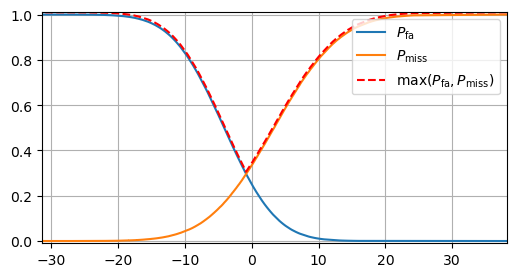

In [6]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()

ax.cla()

ax.plot(thresholds, fpr, label="$P_\mathrm{fa}$")
ax.plot(thresholds, fnr, label="$P_\mathrm{miss}$")
ax.plot(thresholds, np.maximum(fpr, fnr) + eps, "--", color="r", label="$\max(P_\mathrm{fa}, P_\mathrm{miss})$")

ax.set_xlim(min(thresholds[1:-1])-eps, max(thresholds[1:-1])+eps)
ax.set_ylim(0-eps, 1+eps)

ax.legend(fontsize=10, loc="upper right");
ax.grid(True)

plt.show();

fig.savefig("fpr_fnr.png", bbox_inches="tight", dpi=300)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


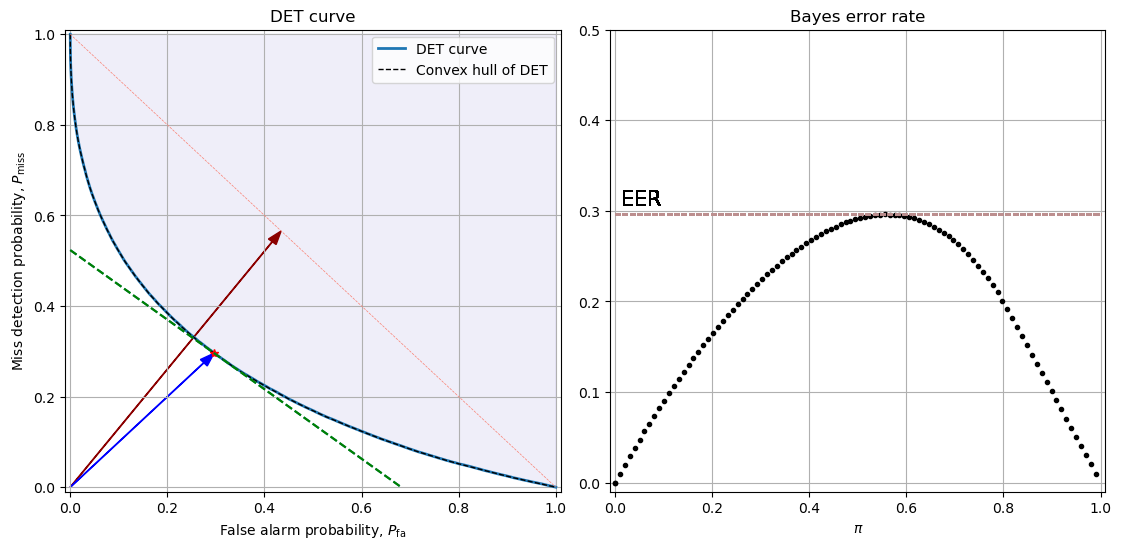

Done!


In [7]:
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.1)
cmap = plt.get_cmap("tab10")

num_steps = 100
num_steps_extra = 30

prior_tar = np.linspace(0, 1, num_steps)

R_min = []
R_min_idx = []

PP = P # P_hull

pbar = tqdm(total=num_steps)


def animate(frame):

    # subplot 1
    ax.cla()
    
    ax.plot(P[:, 0], P[:, 1], linewidth=2, label="DET curve") # [P_fa, P_miss]
    ax.plot(P[:, 0][idxs_hull], P[:, 1][idxs_hull], "k--", linewidth=1, label="Convex hull of DET")
    ax.plot([0, 1], [1, 0], "--", color="salmon", linewidth=0.5);

    ax.fill(np.r_[[0], fpr[idxs_hull], [1]], np.r_[[1], fnr[idxs_hull], [1]], color="slateblue", alpha=0.1)
    
    ax.set_xlabel("False alarm probability, $P_\mathrm{fa}$")
    ax.set_ylabel("Miss detection probability, $P_\mathrm{miss}$")
    ax.set_title(f"DET curve")  
    ax.legend(fontsize=10, loc="upper right")
    ax.set_xlim(0-eps, 1+eps)
    ax.set_ylim(0-eps, 1+eps)
    ax.grid(True)

    # subplot 2
    ax2.plot([0, 1], [EER, EER], "--", color="rosybrown", linewidth=1)
    draw_text(ax2, 0, EER, "$\mathrm{EER}$", fontsize=15)
    
    ax2.set_xlabel("$\pi$")
    # ax2.set_ylabel("")
    ax2.set_title(f"Bayes error rate")  
    # ax2.legend(fontsize=10, loc="upper left")
    ax2.set_xlim(0-eps, 1+eps)
    ax2.set_ylim(0-eps, 0.5)
    ax2.grid(True)
    
    if frame < num_steps - 1:

        pbar.update()
    
        m = len(prior_tar)
        
        # for j in range(m):
        j = frame
 
        prior = np.array([1 - prior_tar[j], prior_tar[j]])    
        R = np.dot(PP, prior);
        idx = np.argmin(R)
        P_min = [PP[:, 0][idx], PP[:, 1][idx]];
        proj = (np.dot(P_min, prior) / np.dot(prior, prior)) * prior
        r = R[idx]
        R_min.append(r)
        R_min_idx.append(idx)
        
        # subplot 1
        ax.plot(P_min[0], P_min[1], "k.")
        ax.arrow(0, 0, P_min[0], P_min[1], color="blue", head_width=0.02, head_length=0.03, length_includes_head=True)
        ax.arrow(0, 0, prior[0], prior[1], color="darkred", head_width=0.02, head_length=0.03, length_includes_head=True)
        ax.arrow(0, 0, proj[0], proj[1], color="black", head_width=0.02, head_length=0.03, length_includes_head=True)
    
        k = (PP[:, 1][idx] - proj[1]) / (PP[:, 0][idx] - proj[0])
        b = PP[:, 1][idx] - k * PP[:, 0][idx]
        ax.plot([0, -b/k], [b, 0], "--", color="teal");
        
        draw_text(ax, prior[0], prior[1], "$[1 - \pi, \pi]$")
        draw_text(ax, P_min[0], P_min[1], "$[P_\mathrm{fa}, P_\mathrm{miss}]$")

        # subplot 2
        ax2.plot(prior_tar[j], r, "k.")

    else:

        idx_max = np.argmax(R_min)

        prior = np.array([1 - prior_tar[idx_max], prior_tar[idx_max]])
        ax.arrow(0, 0, prior[0], prior[1], color="darkred", head_width=0.02, head_length=0.03, length_includes_head=True)
        
        k = -prior[0] / prior[1]

        derivative = np.diff(fnr[idxs_hull]) / np.diff(fpr[idxs_hull])
        
        idx = np.argmin(np.abs(derivative - k))
        
        P_eer0 = [fpr[idxs_hull][idx-1], fnr[idxs_hull][idx-1]]
        P_eer1 = [fpr[idxs_hull][idx], fnr[idxs_hull][idx]]

        ax.plot(P_eer0[0], P_eer0[1], "r*")
        ax.plot([P_eer0[0], P_eer1[0]], [P_eer0[1], P_eer1[1]], "r") # EER segment
        ax.arrow(0, 0, P_eer0[0], P_eer0[1], color="blue", head_width=0.02, head_length=0.03, length_includes_head=True)
        
        
        b = P_eer0[1] - k * P_eer0[0]
        idx_step = frame - num_steps + 1
        b_step = np.linspace(0, b, num_steps_extra + 1)[idx_step]
        
        ax.plot([0, -b/k], [b, 0], "--", color="teal");
        ax.plot([0, -b_step/k], [b_step, 0], "--", color="green");
    
    return [ax, ax2]



# fig.suptitle("")

frames_interval_ms = 10 # milliseconds
ani = FuncAnimation(fig, animate, frames=np.arange(0, num_steps + num_steps_extra), interval=frames_interval_ms, repeat=False)

ani.save("det_curve.gif")

pbar.close()

plt.show();

print("Done!");